In [1]:
# """
# This was done from my clicked on google mount
# """
##### Connect to the Google Drive Path #####
%cd /content/drive/MyDrive/TFOD1.x_Setup

/content/drive/MyDrive/TFOD1.x_Setup


In [2]:
##### Install the dependencies #####
!pip install -U --pre tensorflow=="2.*"
!pip install tf_slim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
##### Make sure you have pycocotools installed #####
!pip install pycocotools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
##### Get tensorflow/models or cd to parent directory of the repository. #####
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [5]:
##### Compile protobufs and install the object_detection package #####
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [6]:
##### This is basically for installation of 't2' #####
%%bash 
##### That's the reason the path is given #####
cd models/research/object_detection/packages/tf2/
pip install .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/drive/MyDrive/TFOD1.x_Setup/models/research/object_detection/packages/tf2
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1237 sha256=9a0fc06af579e02008ba7f686978457a5ffefc00f7828e98345c03306dbc9e16
  Stored in directory: /tmp/pip-ephem-wheel-cache-s_ljlht8/wheels/f7/81/dd/b85e426d493d080567715efcc46533a99abdcc974241cbdeec
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [7]:
##### Import all necessity liabries #####
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [8]:
##### Move to object detection #####
%cd models/research/

##### Import the object detection #####
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

/content/drive/MyDrive/TFOD1.x_Setup/models/research


In [9]:
##### import the patches #####
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

Model Preparation

In [10]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))

  return model

In [11]:
# http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz

In [12]:
# PATH_TO_LABELS = '/content/models/research/object_detection/data/mscoco_label_map.pbtxt'

# '''
# If I run this then i will get this error because i am now on other directory
# '''

# '''
# !pwd
# /content/drive/MyDrive/TFOD1.x_Setup/models/research
# I m on my research directory.
# '''
# ---------------------------------------------------------------------------
# NotFoundError                             Traceback (most recent call last)
# <ipython-input-12-6df86616407b> in <module>
#       1 # List of the strings that is used to add correct label for each box.
#       2 PATH_TO_LABELS = '/content/models/research/object_detection/data/mscoco_label_map.pbtxt'
# ----> 3 category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# 4 frames
# /usr/local/lib/python3.8/dist-packages/tensorflow/python/lib/io/file_io.py in _preread_check(self)
#      75         raise errors.PermissionDeniedError(None, None,
#      76                                            "File isn't open for reading")
# ---> 77       self._read_buf = _pywrap_file_io.BufferedInputStream(
#      78           compat.path_to_str(self.__name), 1024 * 512)
#      79 

# NotFoundError: /content/models/research/object_detection/data/mscoco_label_map.pbtxt; No such file or directory

In [13]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [14]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('object_detection/test_images/bou3.jpg'),
 PosixPath('object_detection/test_images/car.jpg'),
 PosixPath('object_detection/test_images/girl.jpg')]

In [15]:
##### Model Selection #####
model_name = 'efficientdet_d6_coco17_tpu-32'
detection_model = load_model(model_name)

In [16]:
# http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d6_coco17_tpu-32.tar.gz

Check the model's input signature, it expects a batch of 3-color images of type uint8:

In [17]:
print(detection_model.signatures['serving_default'].inputs)

[<tf.Tensor 'input_tensor:0' shape=(1, None, None, 3) dtype=uint8>, <tf.Tensor 'unknown:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_0:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_1:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_2:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_3:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_4:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_5:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_6:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_7:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_8:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_9:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_10:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_11:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_12:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_13:0' shape=<unknown> dtype=resource>, <tf.Tensor 'unknown_14:0' shape=<unknown> dtype=resource>, <

And returns several outputs:

In [18]:
detection_model.signatures['serving_default'].output_dtypes

{'raw_detection_scores': tf.float32,
 'detection_multiclass_scores': tf.float32,
 'detection_scores': tf.float32,
 'detection_boxes': tf.float32,
 'raw_detection_boxes': tf.float32,
 'detection_anchor_indices': tf.float32,
 'num_detections': tf.float32,
 'detection_classes': tf.float32}

In [19]:
detection_model.signatures['serving_default'].output_shapes

{'raw_detection_scores': TensorShape([1, 371349, 90]),
 'detection_multiclass_scores': TensorShape([1, 100, 90]),
 'detection_scores': TensorShape([1, 100]),
 'detection_boxes': TensorShape([1, 100, 4]),
 'raw_detection_boxes': TensorShape([1, 371349, 4]),
 'detection_anchor_indices': TensorShape([1, 100]),
 'num_detections': TensorShape([1]),
 'detection_classes': TensorShape([1, 100])}

Add a wrapper function to call the model, and cleanup the outputs:

In [20]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Run it on each test image and show the results:

In [21]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

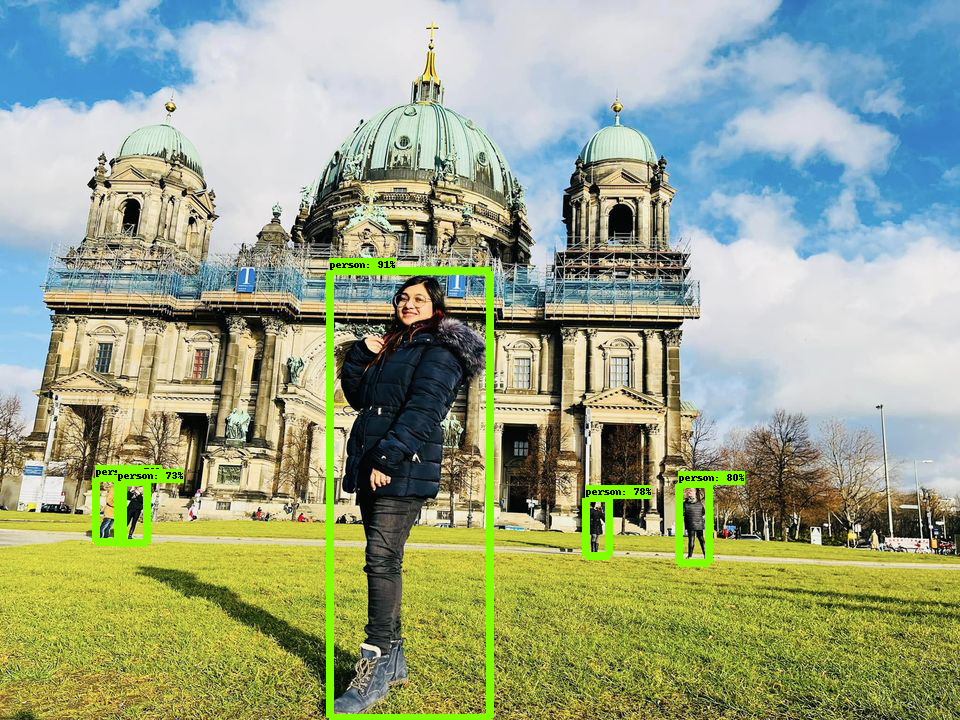

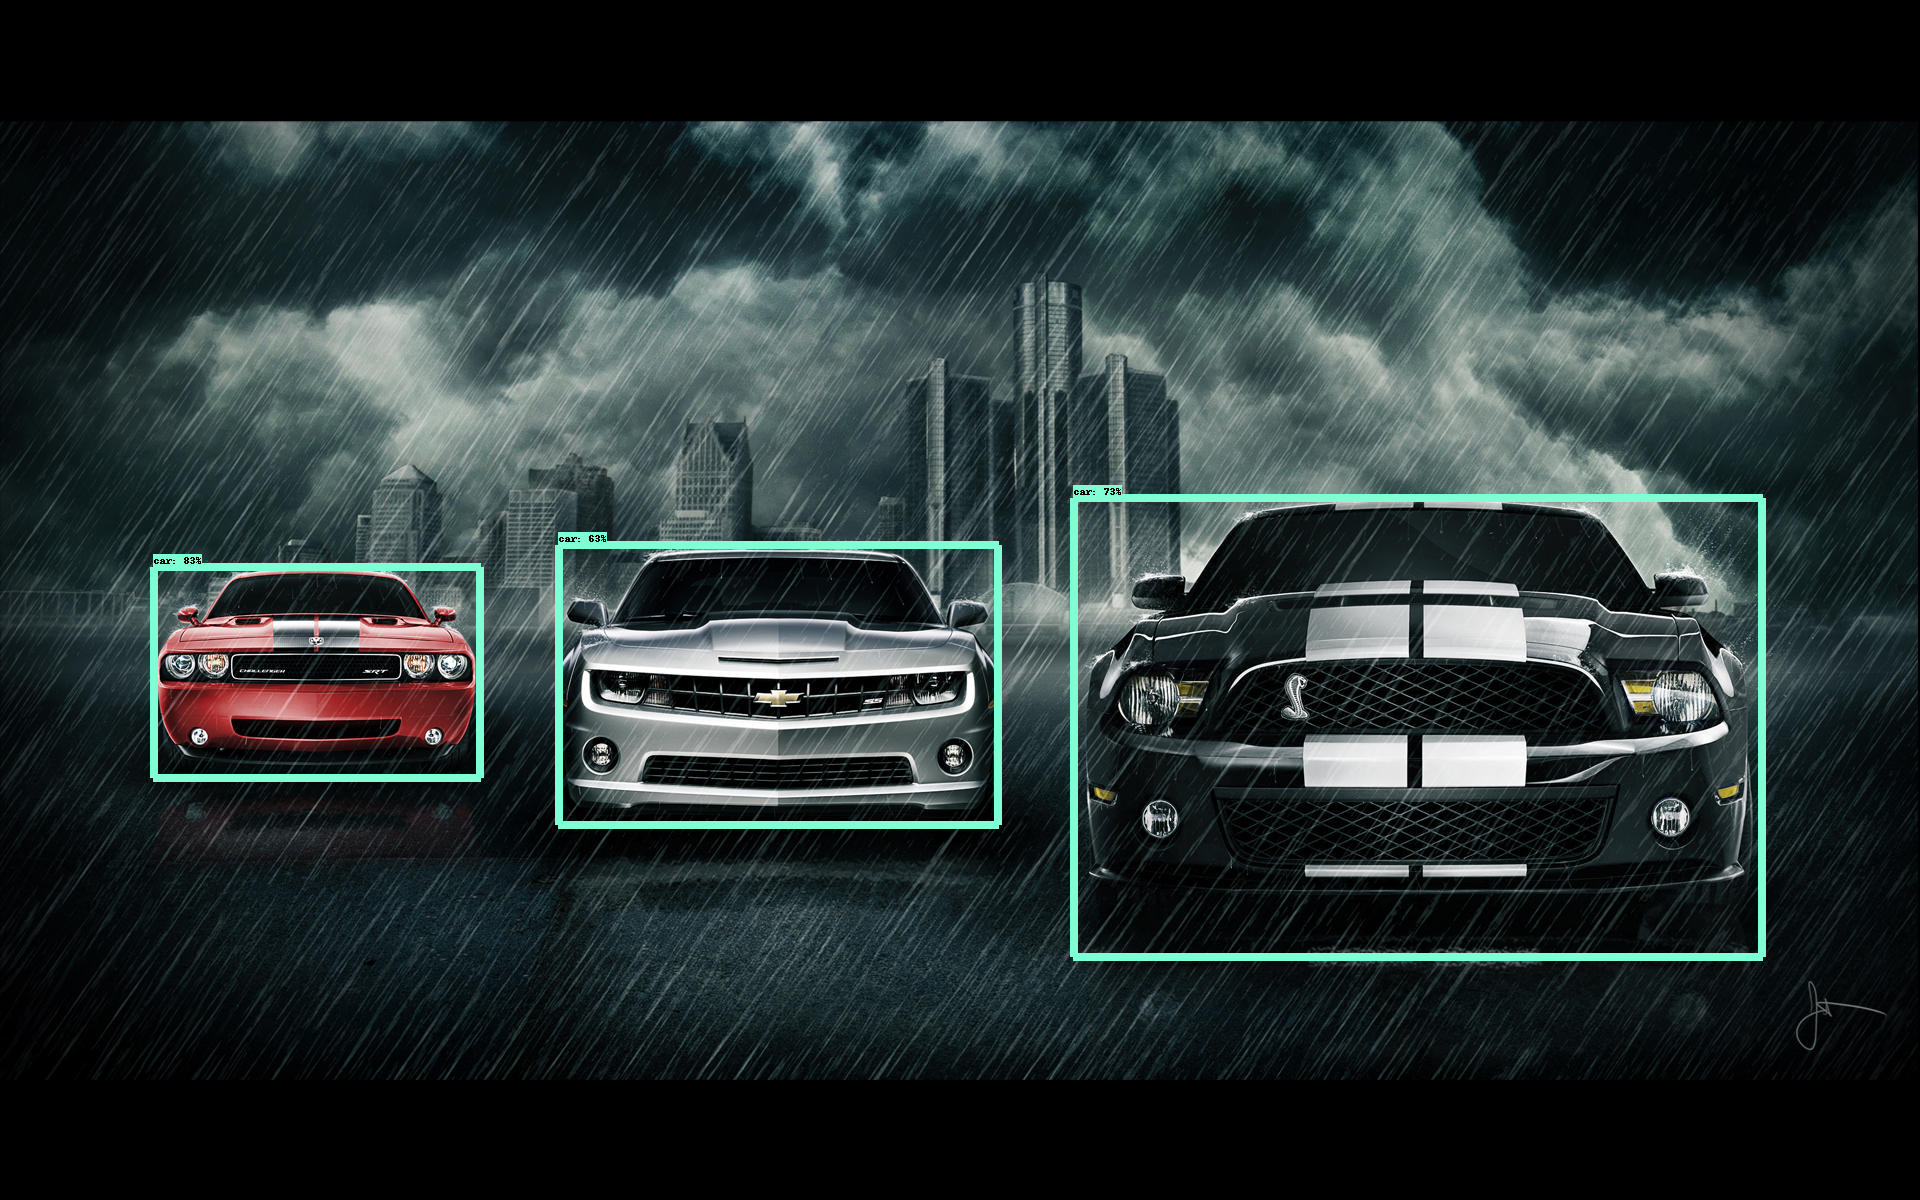

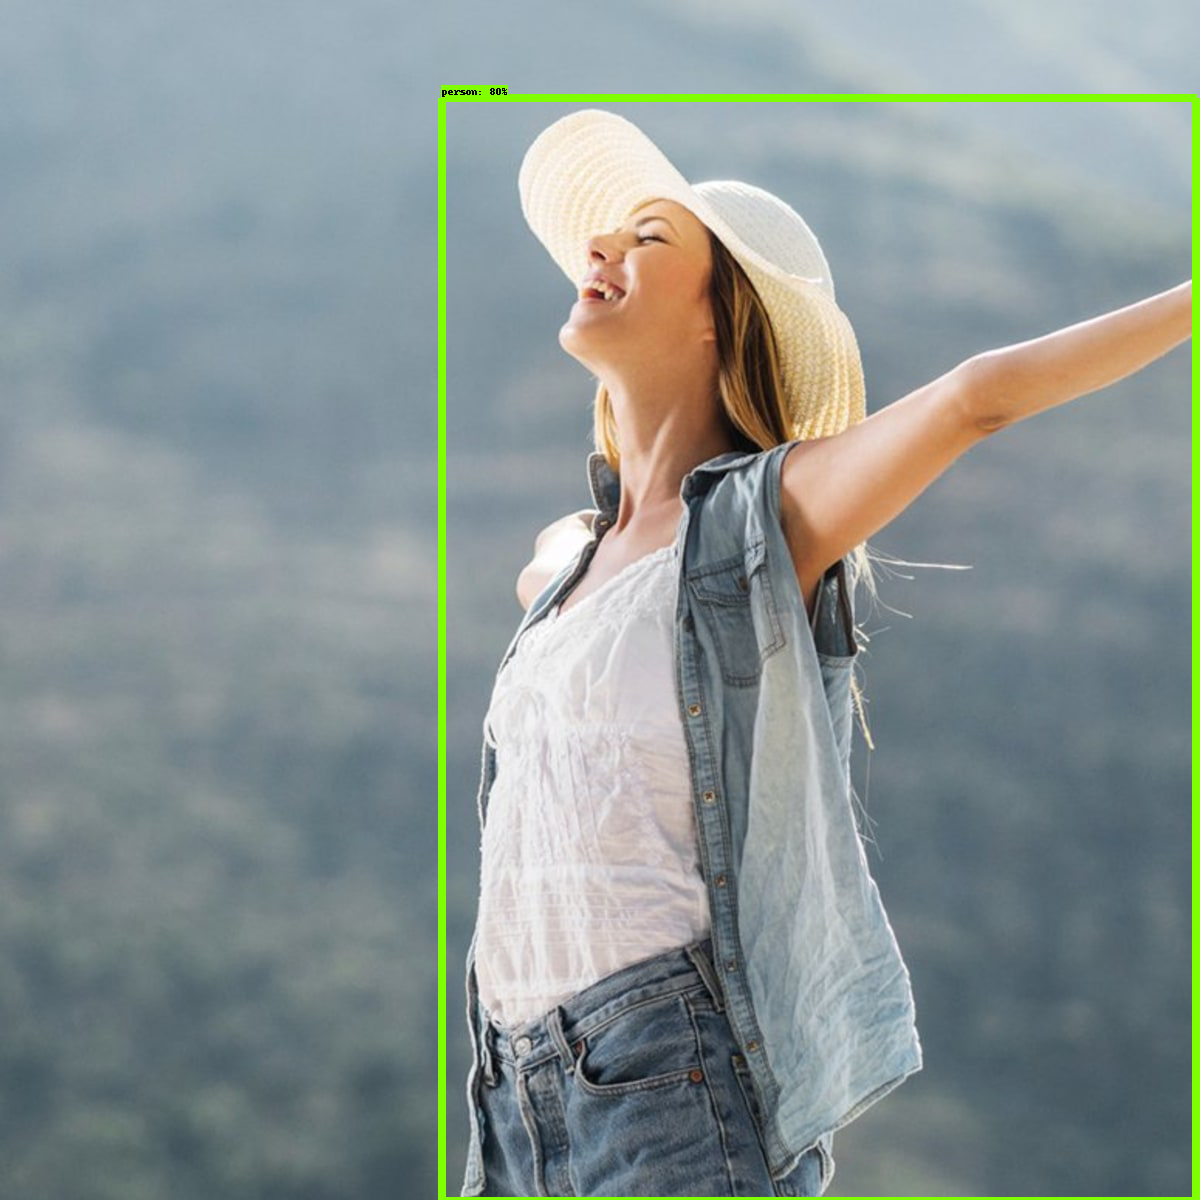

In [22]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)